In [128]:
from statsmodels.tsa.api import SimpleExpSmoothing
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
import statsmodels.api as sm

In [129]:
from warnings import filterwarnings
filterwarnings("ignore")
import pandas as pd

data = pd.read_csv("ghana_gdp.csv", parse_dates=["year"], index_col=["year"], dayfirst=False)
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


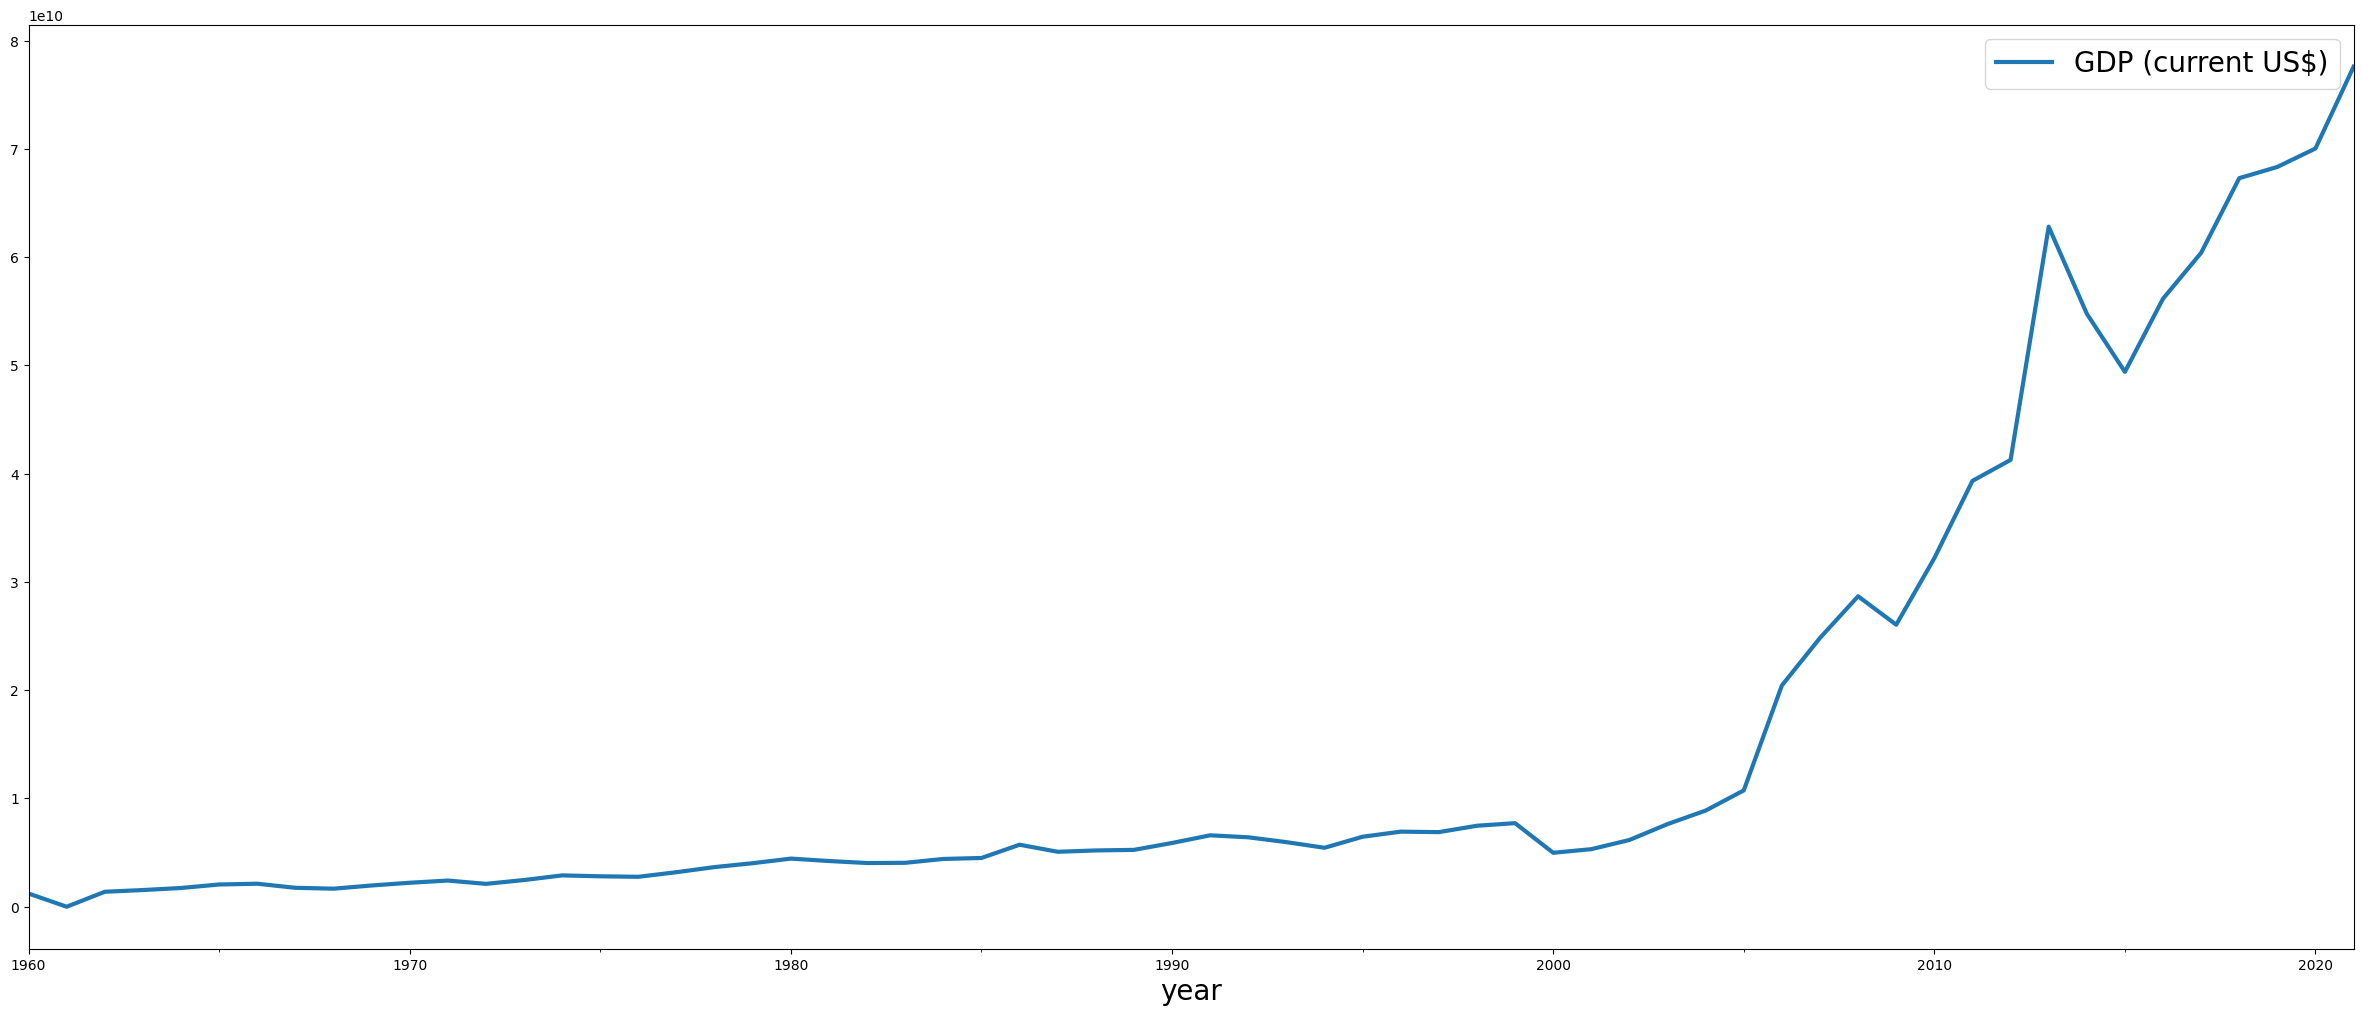

In [130]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()

Из графика видно, что общий тренд есть, хотя показательным он начался только с 2000 года, до этого был очень плавный, либо вообще упал к 2000. Однако затем тренд роста виден. Судить о сезонности тут очень сложно. 

Разобьем выборку на тестовую и тренировочную. В тестовую внесем последние три года

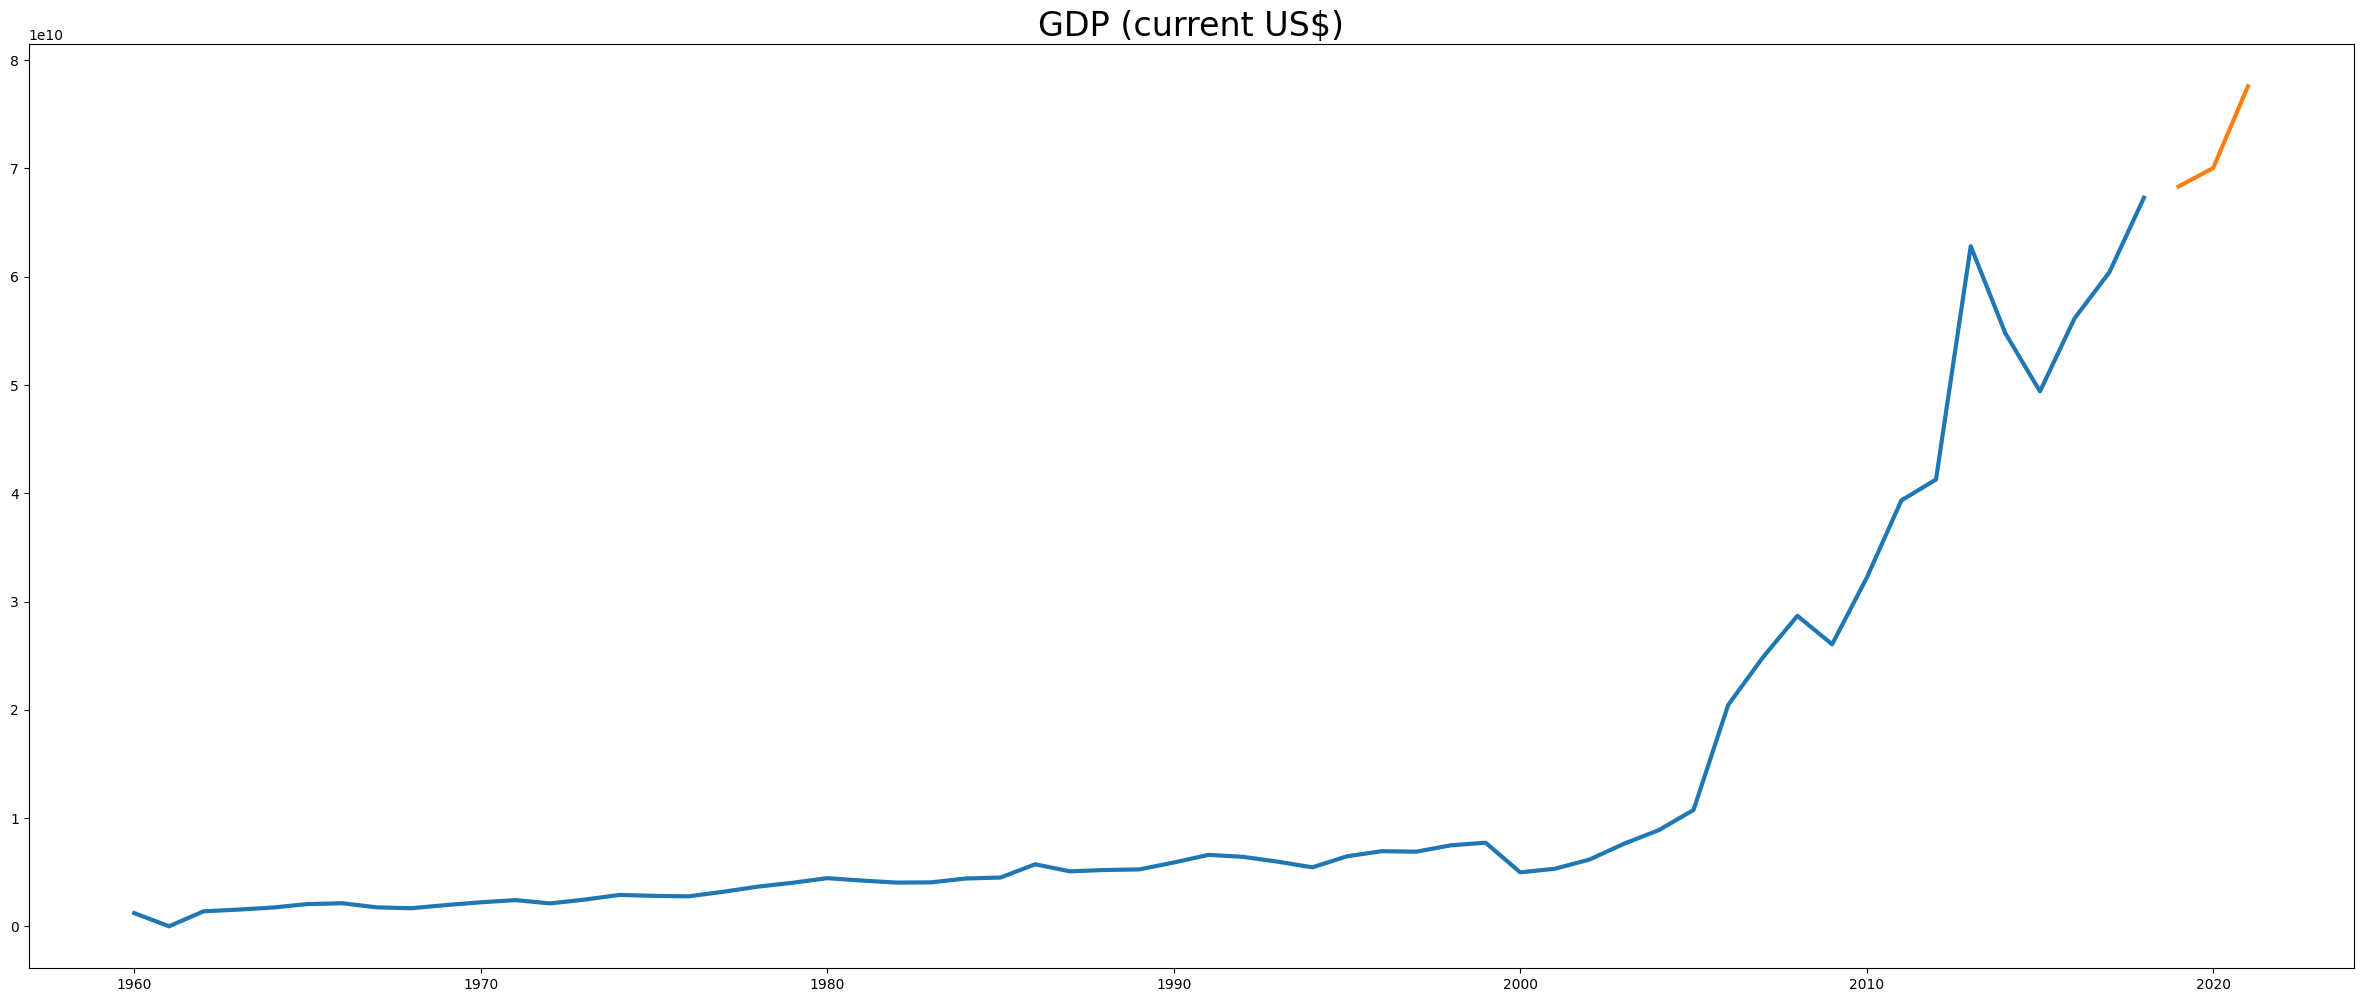

In [116]:
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]

train_df[['GDP (current US$)']].loc[train_df.index.year == 1960]

plt.plot(train_df[['GDP (current US$)']])
plt.plot(test_df[['GDP (current US$)']])
plt.title('GDP (current US$)', size=24)
plt.show()

Построим график скользящего среднего

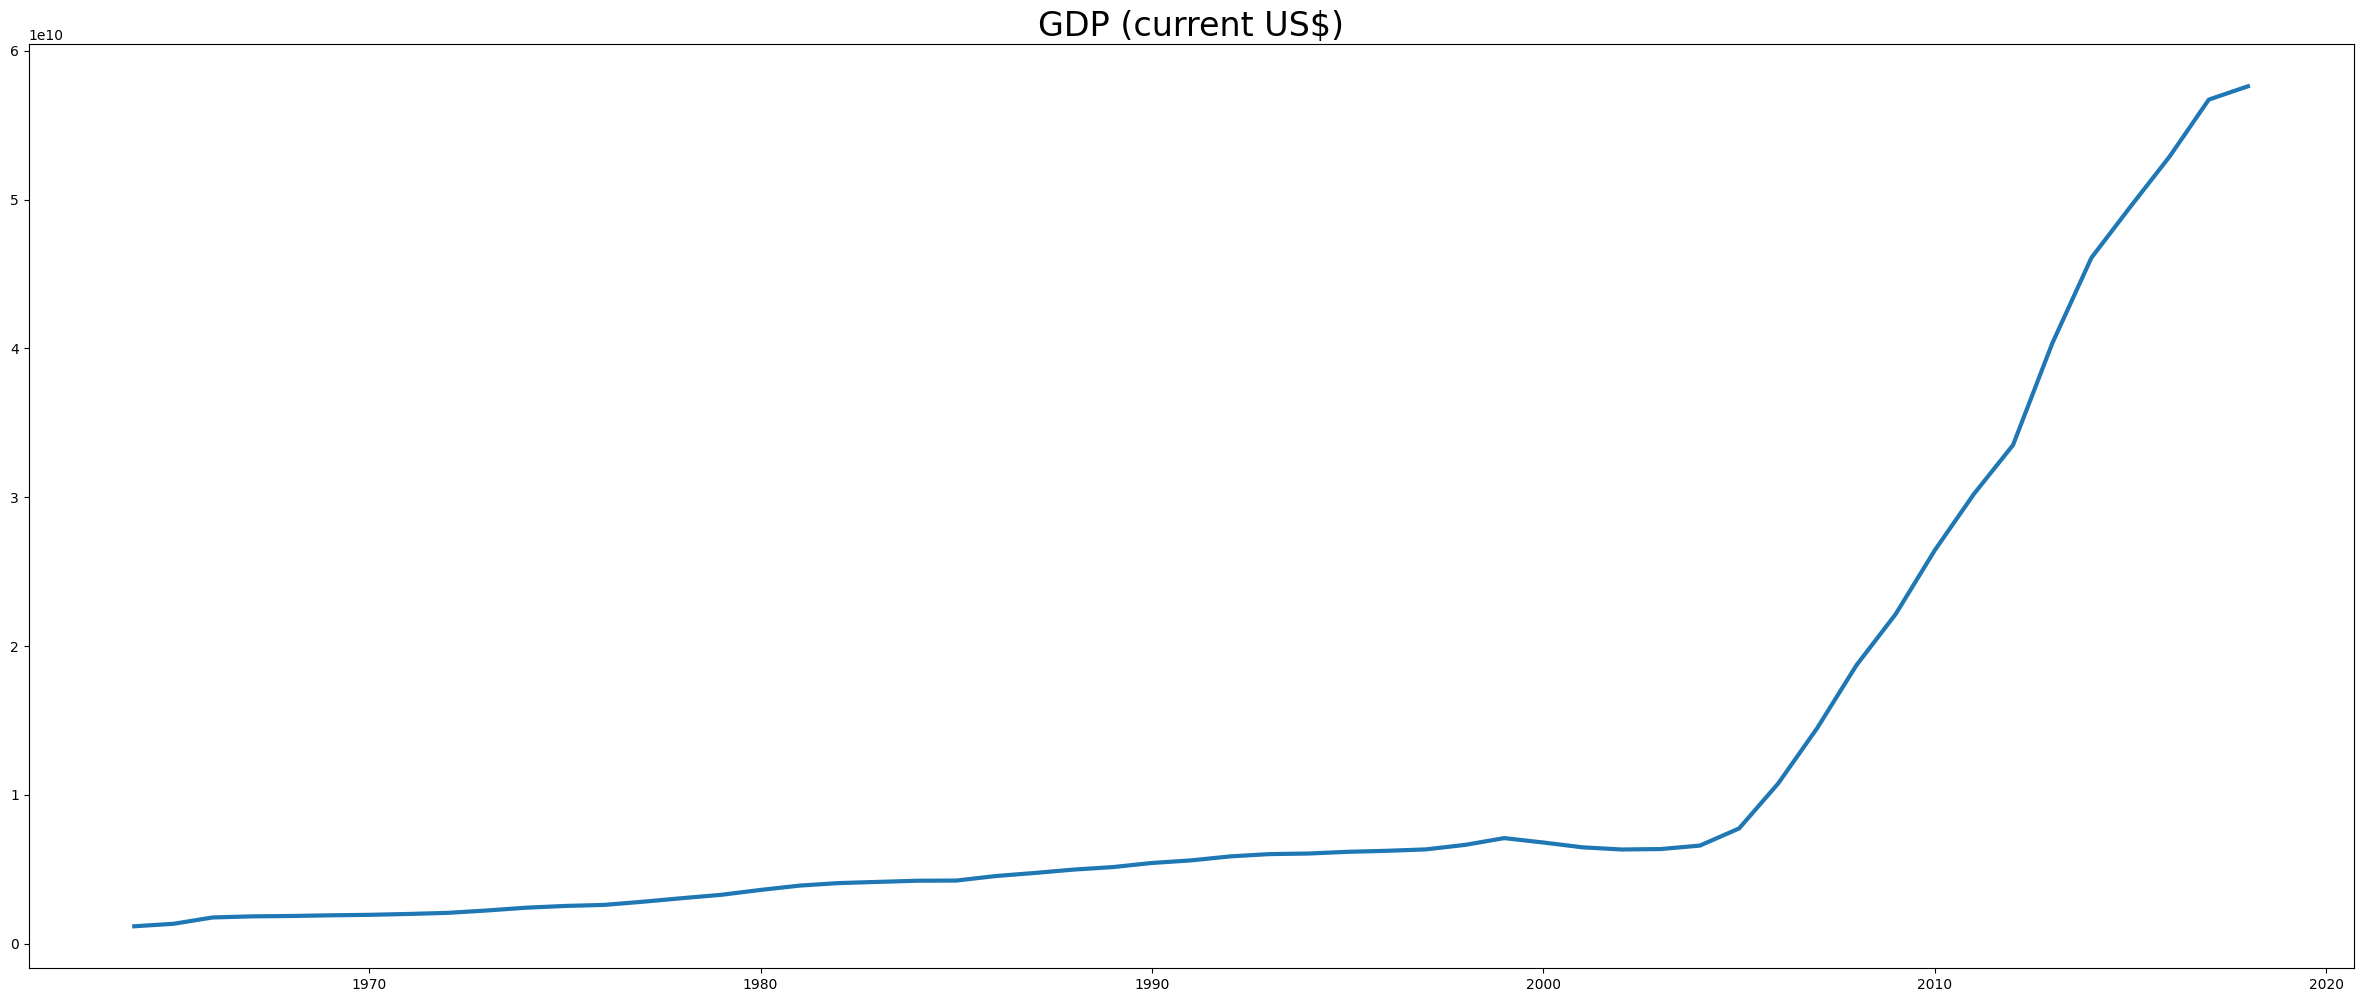

In [117]:
train = train_df.rolling(5).mean()
plt.plot(train[['GDP (current US$)']])
plt.title('GDP (current US$)', size=24)
plt.show()

Как видно из графика, при введенных данных, у нас прослеживается тренд роста. В отличие от первой визуализации, график сгладился и чем больше ширина окна, чем более гладкий становится график

Теперь сделаем сезонную декомпозицию ряда

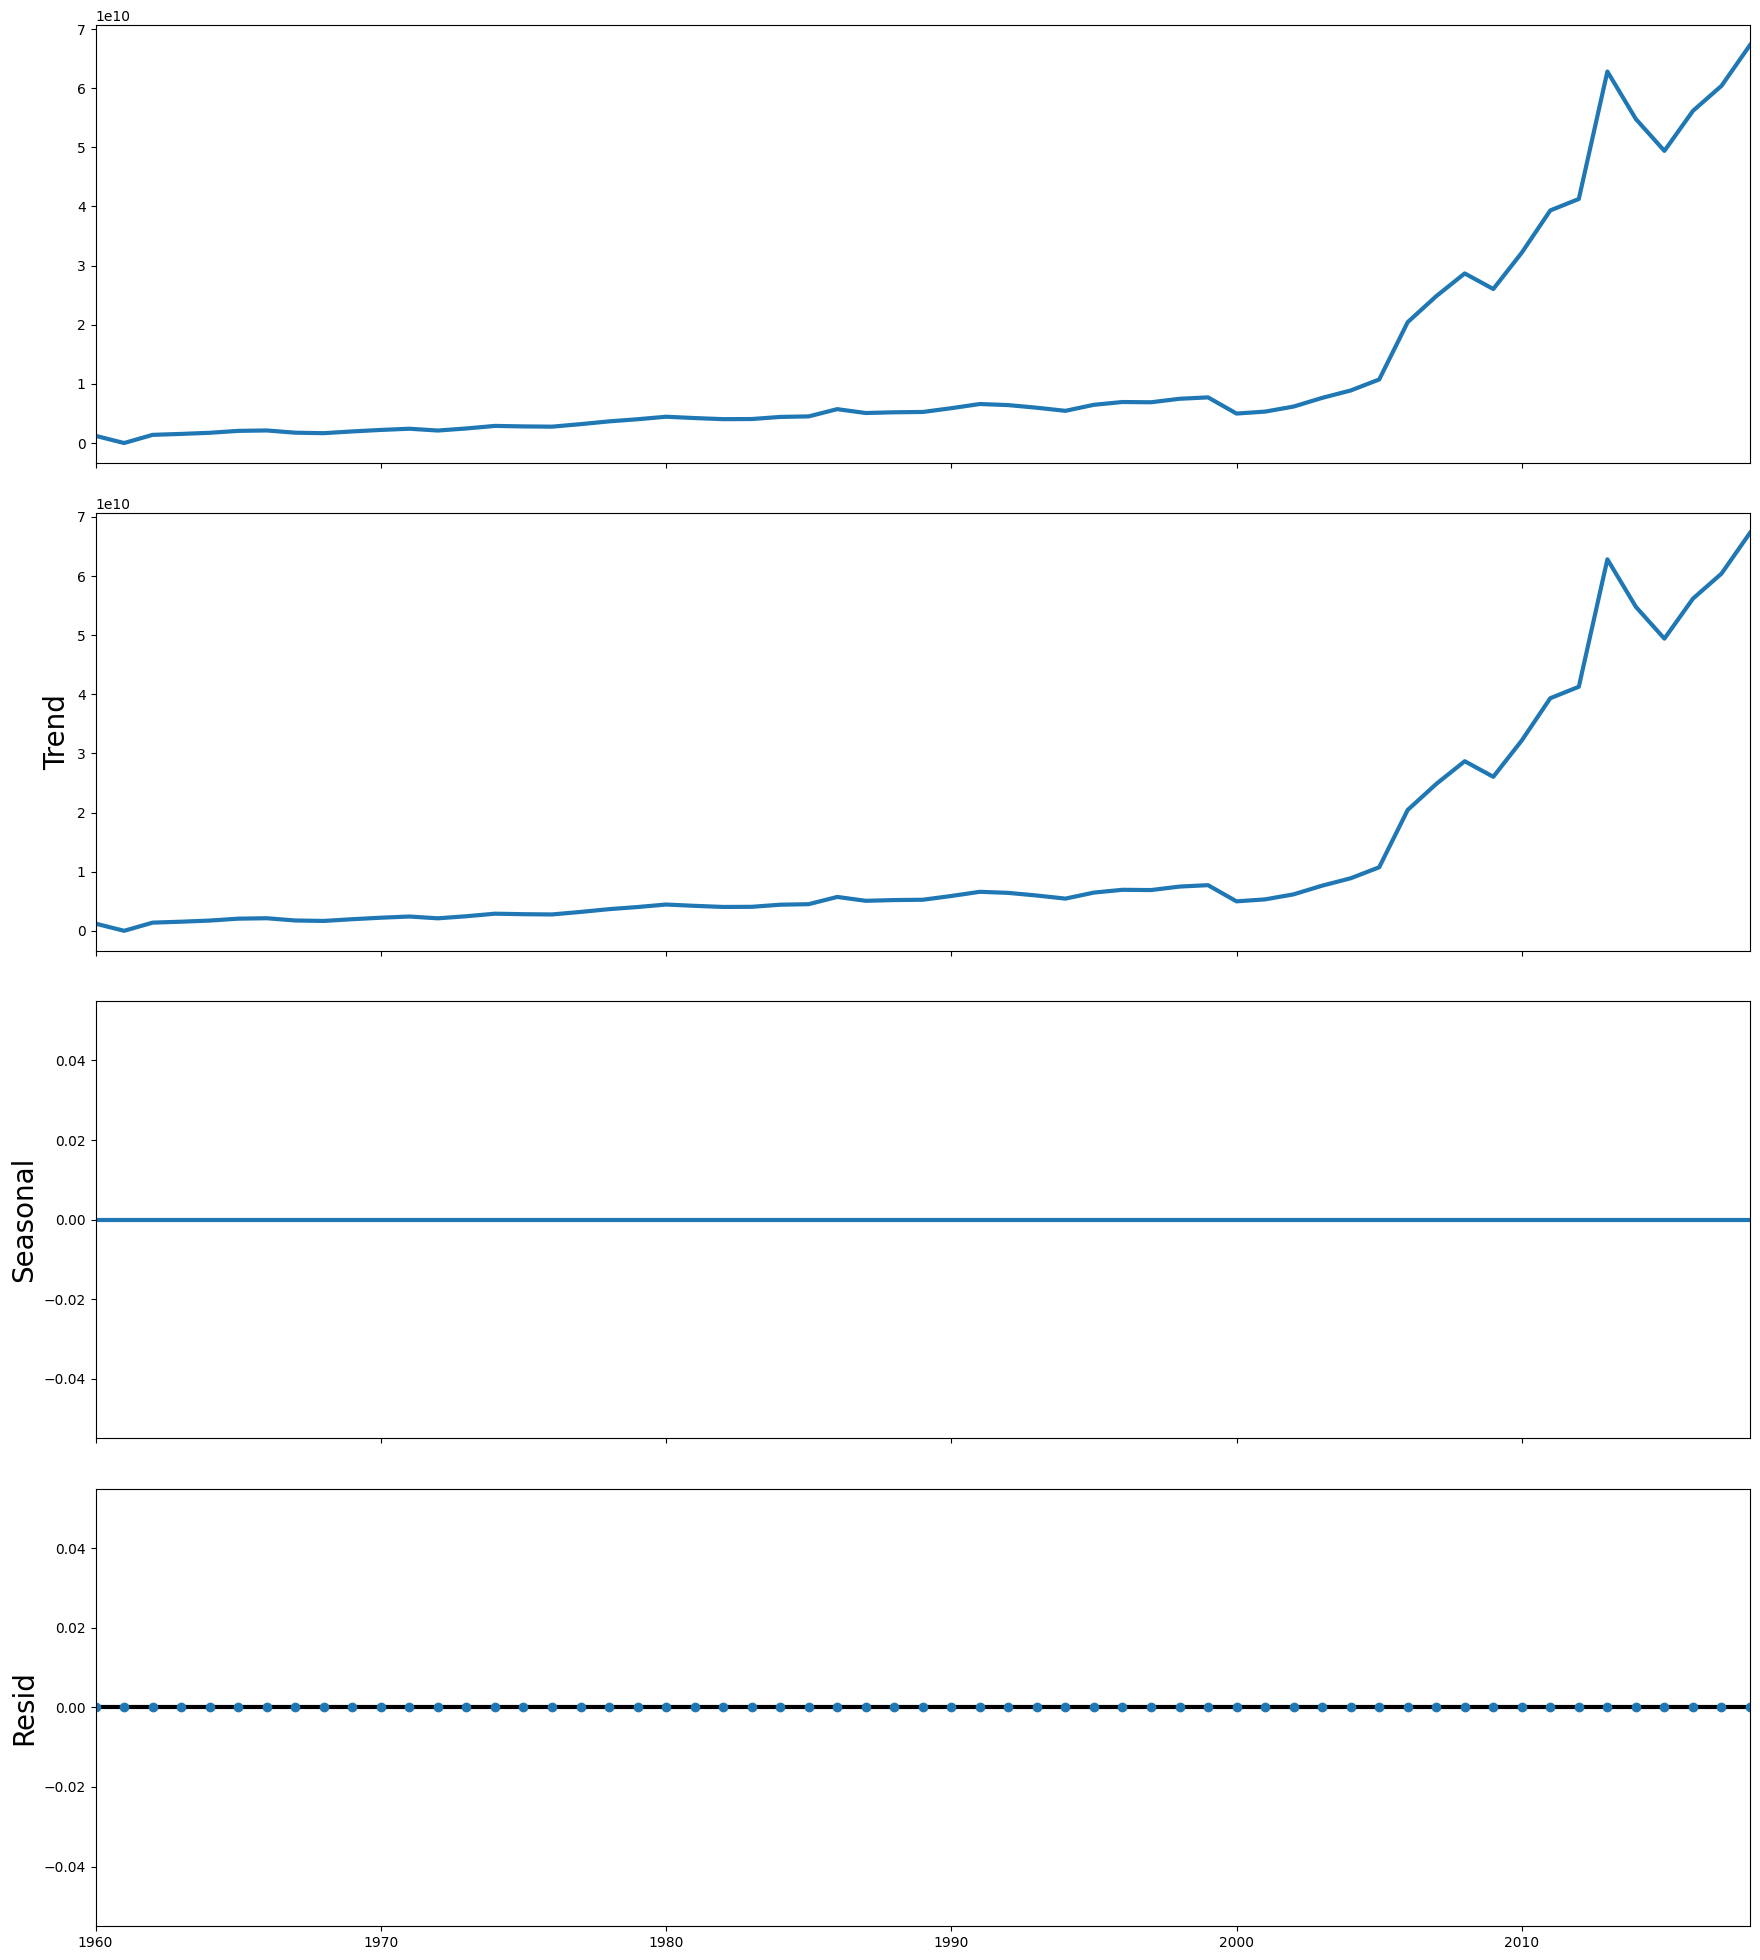

In [118]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df)
result.plot()
plt.show()

Как видно из графиков, есть тренд, особенно с 2000 года. Сезонность при таких данных отсутствует.

Построим коррелограмму для ряда

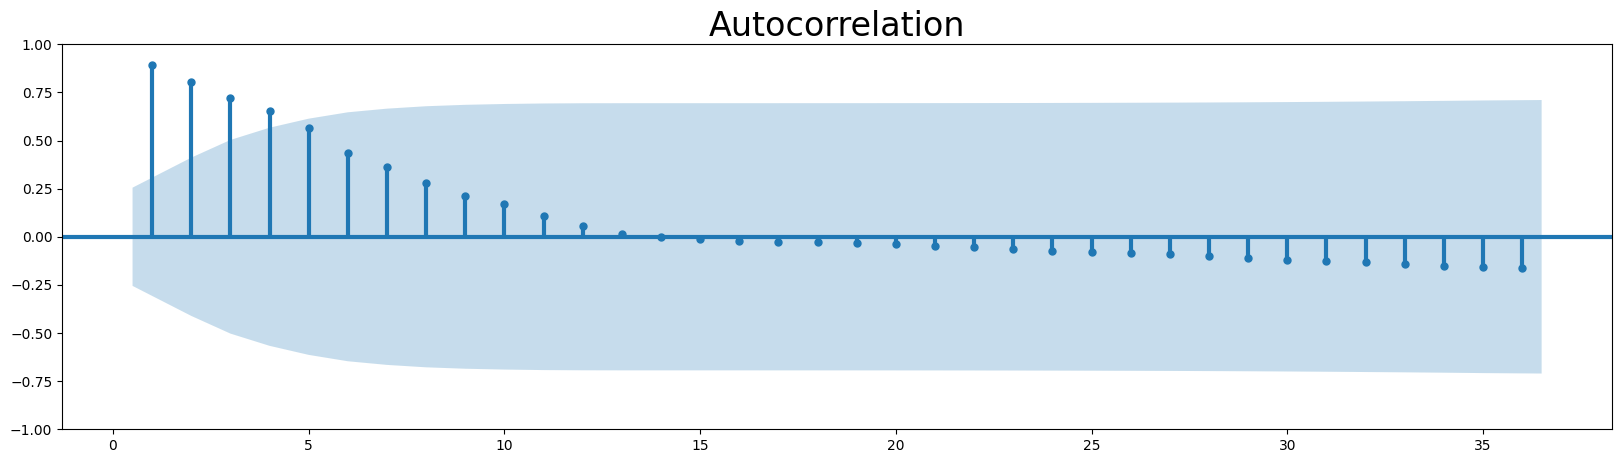

In [119]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df, lags=36, zero=False)
plt.show()

Теперь построим график частичной автокорреляции

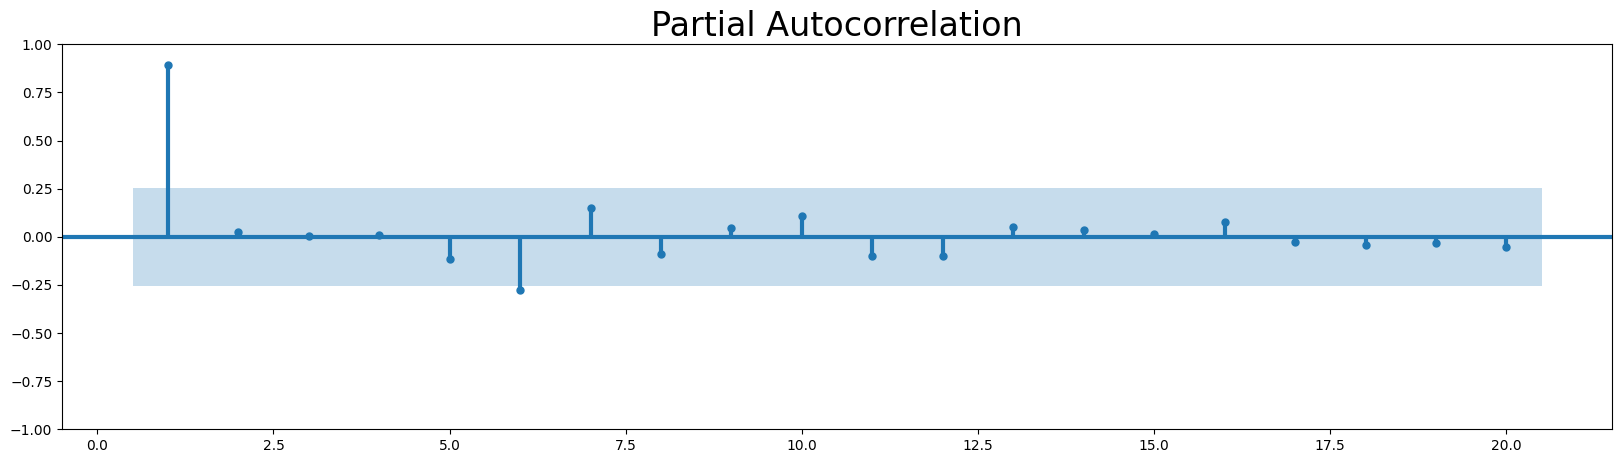

In [127]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df, lags=20, zero=False)
plt.show()

В данном случае, данные никакой новой информации не несут и значение параметра р, выбирается = 1

Проводим тест на стационарность

In [131]:
def stat_test(df):
    test = sm.tsa.adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(train_df)

adf:  0.6529066974885367
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
есть единичные корни, ряд не стационарен


Значение теста больше критических значений, значит ряд не стационарный необходимо привести его к стационарности. Проводим дифференцирование ряда, столько раз,сколько нужно, чтобы он стал стационарным

In [32]:
otg1diff = data.diff(periods=1).dropna()
test1 = sm.tsa.adfuller(otg1diff)
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -1.5879441118004787
p-value:  0.48964671777435276
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен


In [46]:
otg2diff = otg1diff.diff(periods=2).dropna()
test2 = sm.tsa.adfuller(otg2diff)
print ('adf: ', test2[0])
print ('p-value: ', test2[0])
print ('Critical values: ', test2[4])
if test2[0]> test2[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -2.6354900000691233
p-value:  -2.6354900000691233
Critical values:  {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}
ряд нестационарен


In [47]:
otg3diff = otg2diff.diff(periods=3).dropna()
test3 = sm.tsa.adfuller(otg3diff)
print ('adf: ', test3[0])
print ('p-value: ', test3[0])
print ('Critical values: ', test3[4])
if test3[0]> test3[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -3.2357027215687255
p-value:  -3.2357027215687255
Critical values:  {'1%': -3.5885733964124715, '5%': -2.929885661157025, '10%': -2.6031845661157025}
ряд стационарен


В итоге, нам понадобилось 3 попытки, чтоюы привести ряд к стационарности. Т.о. значение d = 3

Теперь построим графики автокорреляции для стационарного ряда.

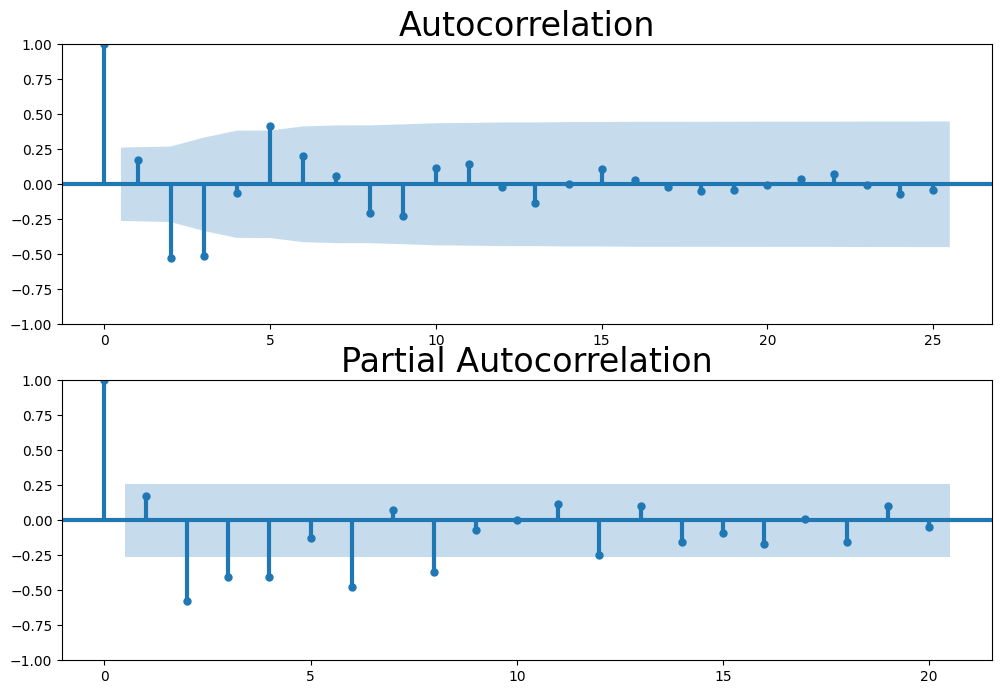

In [111]:
from matplotlib import pyplot as plt
%matplotlib inline 

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(otg3diff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(otg3diff, lags=20, ax=ax2)

Как видно из графика частичной автокорреляции, визуализация изменилась по сравнению с начальной, но, в основном, все данные находятся возле 0

Так как у нас нет сезонности, то построим модель **ARIMA** со следующими параметрами:

- p = 1 
- d = 3 к-во дифференцирований. У нас - 3.
- q = 1 

In [132]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df["GDP (current US$)"].dropna(), order=(1, 3, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 3, 1)   Log Likelihood               -1332.455
Date:                Tue, 23 Jan 2024   AIC                           2670.910
Time:                        09:55:39   BIC                           2676.986
Sample:                    01-01-1960   HQIC                          2673.266
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5073      0.091     -5.600      0.000      -0.685      -0.330
ma.L1         -0.9751      0.132     -7.380      0.000      -1.234      -0.716
sigma2      4.066e+19   1.88e-21   2.17e+40      0.000    4.07e+19    4.07e+19
===================================================================================
Ljung-Box (L1) (Q):                   3.34   Jarque-Bera (JB):               140.21
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):             441.28   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.37e+55. Standard errors may be unstable.
"""

Построим модель предсказания.

In [133]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["GDP (current US$)"] = data["GDP (current US$)"]

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

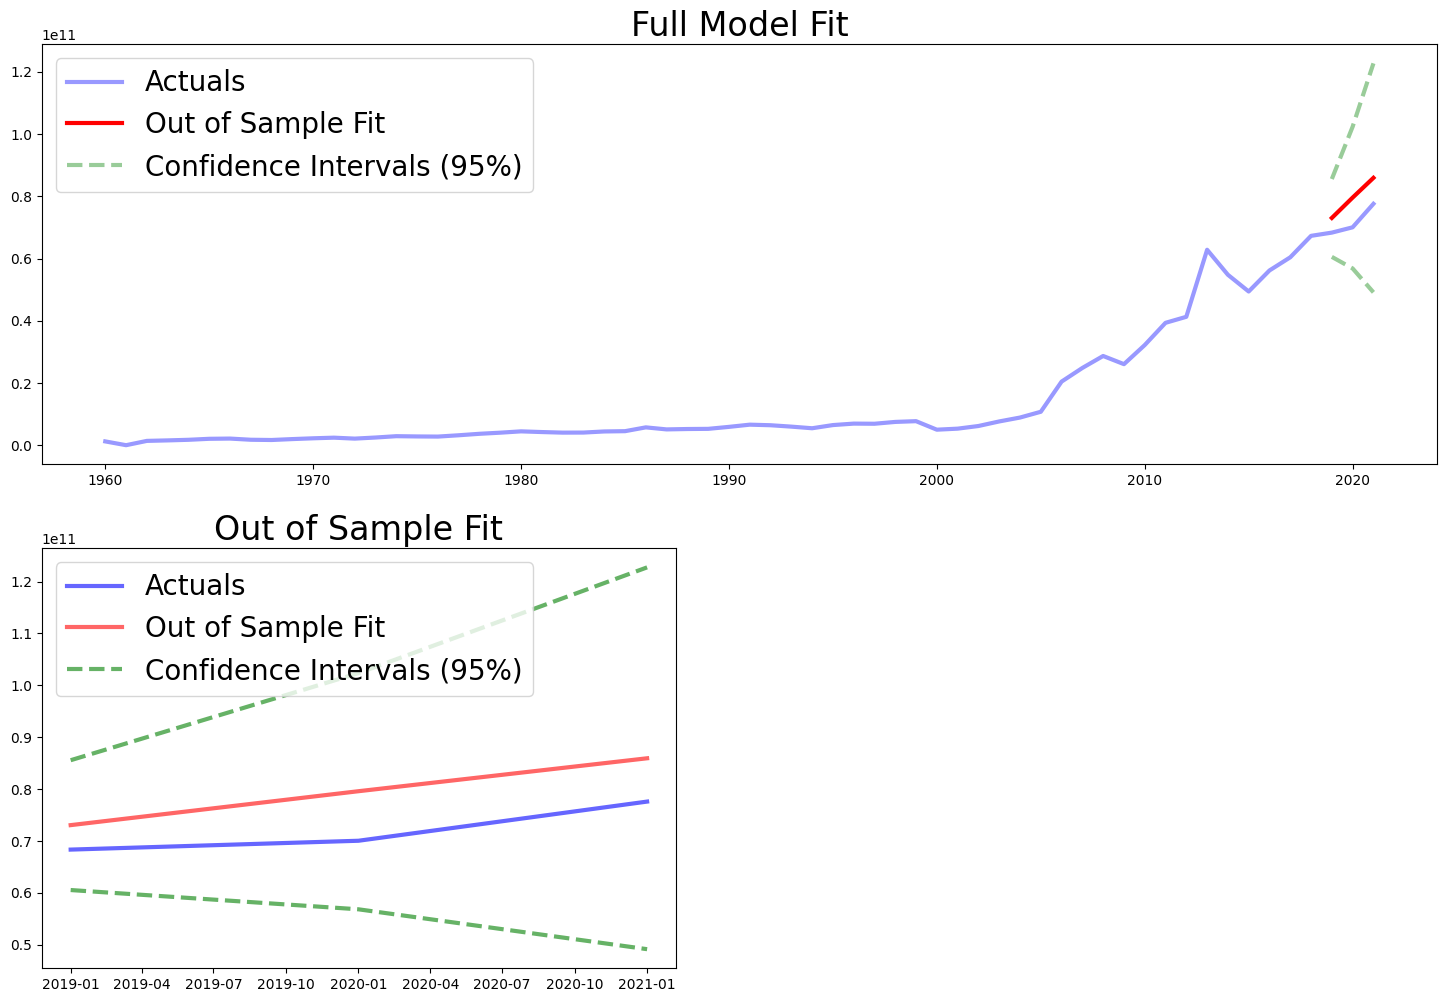

In [134]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

#### Как видно. в предскзании тренд на рост также есть, хотя нижняя часть доверительного интервала ведет себя странно.

Найдем наиболее подходящие параметры, используя пакет pmdarima

In [135]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1, #стартовое значение, мы брали р = 1
    d=3,
    start_q=1,
    max_p=3,
    max_q=3,
    D=1,
    start_P=0,
    m=1,#это сезонность, у нас была 5, поэтому ставим ее
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.04 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.00 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.02 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.03 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.01 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.05 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.03 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.02 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.550 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Tue, 23 Jan 2024   AIC                           2659.231
Time:                        09:57:56   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.52e+56. Standard errors may be unstable.
"""

Модель предсказала наилучший вариант - ARIMA(2,3,1)(0,0,0)[0]. Построим с этими данными

In [144]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df["GDP (current US$)"].dropna(), order=(2, 3, 1))
arima_model_fit_2 = arima_model.fit()
arima_model_fit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Tue, 23 Jan 2024   AIC                           2659.231
Time:                        10:03:32   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.52e+56. Standard errors may be unstable.
"""

In [145]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_fit_2.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["GDP (current US$)"] = data["GDP (current US$)"]

forecast = arima_model_fit_2.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

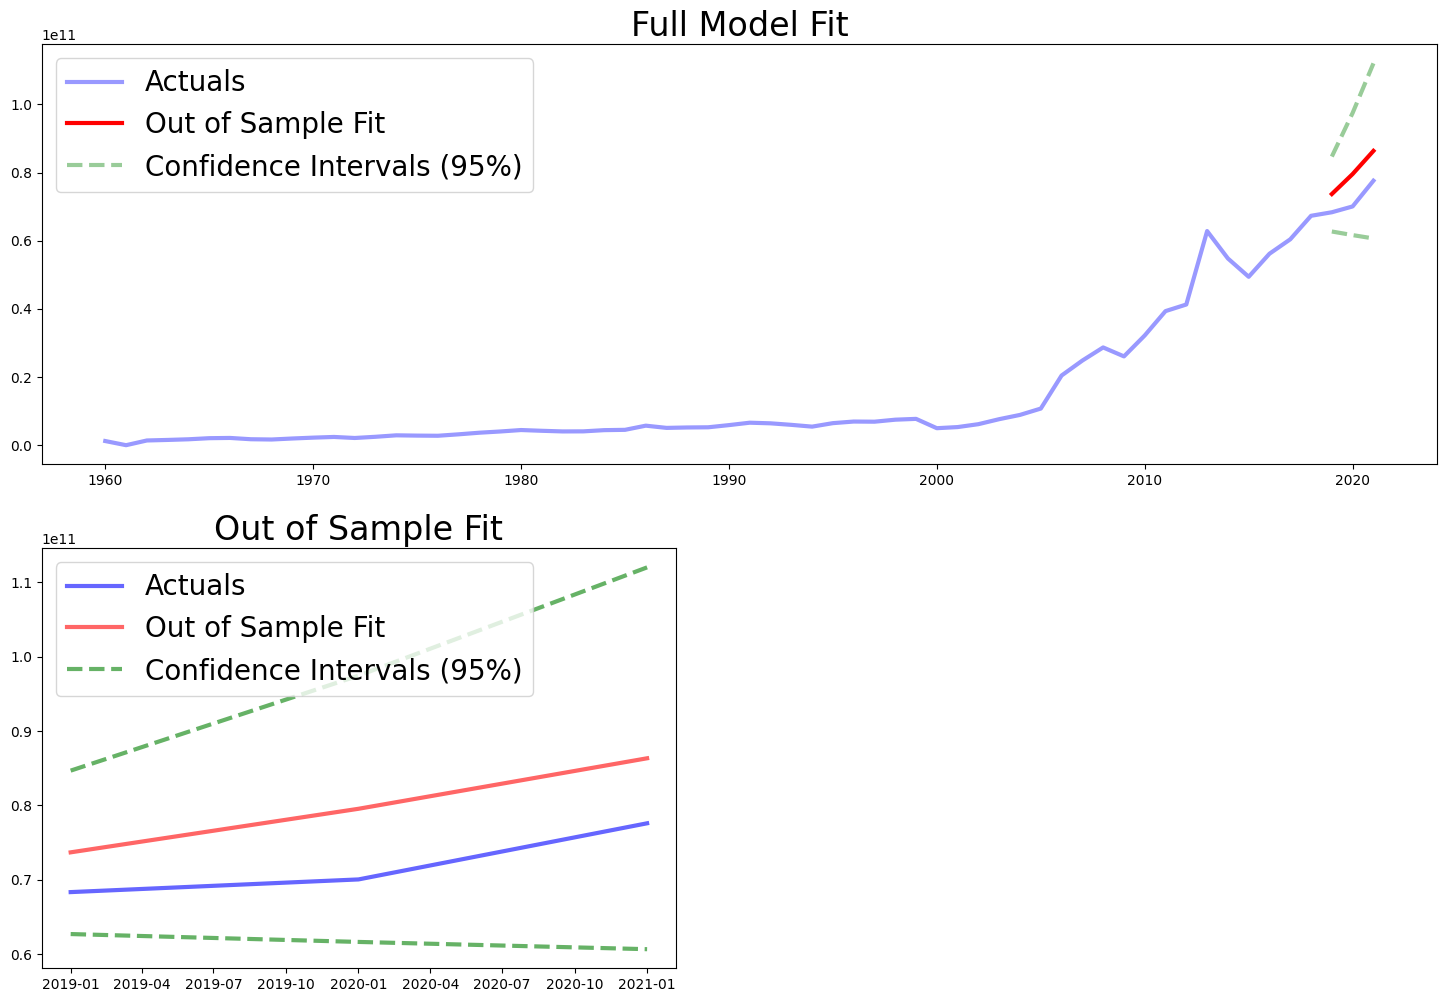

In [146]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

### Как видно, с данными, предсказанными моделью, предсказание, на мой взгляд более четкое, и тренд более плавный, как видно из всего анализа выше. Хотя общая идея осталась схожей - тренд роста.